In [116]:
%load_ext autoreload
%autoreload 2
from functional_neural_networks.dense import FunctionalDense
from hyperopt.fnn import HyperOptFnn
from hyperopt.sklearn_gridsearch import HyperOptScikitFda
from shapley.shapley_fda import ShapleyFda
from skfda.exploratory.stats import cov
from skfda.misc.operators import LinearDifferentialOperator
from skfda.misc.regularization import L2Regularization
from skfda.ml.regression import KNeighborsRegressor, LinearRegression
from skfda.representation.basis import BSplineBasis
from utils.predict_np import predict_from_np
from utils.simulator import FdaSimulator
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
n_basis_representation = 11
basis_bsplines = BSplineBasis(
    n_basis=n_basis_representation,
    domain_range=(0 ,1)
)

In [34]:
fda_simulator = FdaSimulator()

In [38]:
# Prepare some global parameters used to generate data
cnt = 30
alpha_p =  1 * cnt
beta_p = 3 * cnt
positions = [0.15, 0.35, 0.55, 0.85]
n_basis_simulated_data = 11

X, phi_X, epsilon, beta_data, col_indexes_bct, target = fda_simulator.simulate(
    type_covariate="fourier_expansion",
    type_transformation="linear_unimodal",
    sample_size=200,
    eta=0.05,
    datasets_type = ["train", "validation", "test"],
    # Series representation
    n_basis_simulated_data=n_basis_simulated_data,
    sd_x=0.01,
    # Beta parameters
    alpha_param=alpha_p,
    beta_param=beta_p,
    # Brownian parameters
    intercept_brownian=0,
    slope_brownian=1,
    positions=positions
)

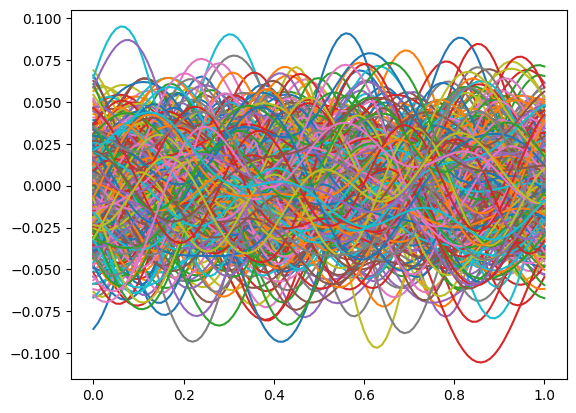

In [39]:
X_train, X_validation, X_test = X
X_full = np.row_stack((X_train, X_validation))

target_train, target_validation, target_test = target
target_full = np.row_stack((target_train, target_validation))

beta_train, beta_validation, beta_test = beta_data

X_train_grid = fda_simulator.to_fdata_grid(X_train)
X_validation_grid = fda_simulator.to_fdata_grid(X_validation)
X_test_grid = fda_simulator.to_fdata_grid(X_test)
X_full_grid = fda_simulator.to_fdata_grid(X_full)

X_train_bspline = X_train_grid.to_basis(basis_bsplines)
X_validation_bspline = X_validation_grid.to_basis(basis_bsplines)
X_test_bspline = X_test_grid.to_basis(basis_bsplines)
X_full_bspline = X_full_grid.to_basis(basis_bsplines)
zzz = X_full_grid.plot()

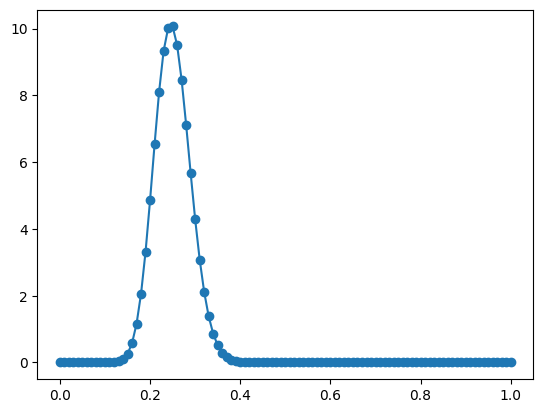

In [40]:
if not beta_train is None:
    beta_data_grid = fda_simulator.to_fdata_grid(beta_train)
    plt.plot(
        fda_simulator.abscissa_points,
        np.reshape(beta_train, newshape=(1, -1))[0], '-o'
    )

# Linear model

In [26]:
def L2reg(lambda_value):
    operator = L2Regularization(
        linear_operator=LinearDifferentialOperator(2),
        regularization_parameter=lambda_value
    )
    return operator

In [27]:
hyperopt_lm = HyperOptScikitFda(
    LinearRegression,
    abscissa_points=fda_simulator.abscissa_points,
    domain_range=fda_simulator.domain_range,
)
reg_list = [L2reg(x) for x in np.arange(0.2, 1.5, 0.2)]
reg_list.append(None)
params_lm = {
    "regularization": reg_list
}
hist_lm = hyperopt_lm.search(
    params=params_lm,
    X_train=X_train_bspline,
    y_train=target_train[:, 0],
    X_val=X_validation_bspline,
    y_val=target_validation[:, 0]
)

In [28]:
best_params_lm = hist_lm.best_params_
print(best_params_lm)
best_model_lm = hyperopt_lm.cls_estimator(**best_params_lm)

{'regularization': None}


In [29]:
_ = best_model_lm.fit(X_full_bspline, target_full[:, 0])

In [70]:
num_intervals = 20
num_permutations = 1000

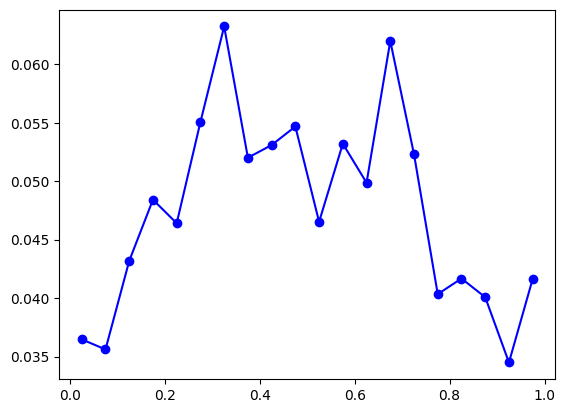

In [31]:
# Transform predict function to use a numpy array as input
pred_lm = predict_from_np(
    grid_points=fda_simulator.abscissa_points,
    domain_range=fda_simulator.domain_range,
    basis=X_full_bspline.basis,
    predict_fn=best_model_lm.predict
)

shapley_fda_lm = ShapleyFda(
    predict_fn=pred_lm,
    X=X_test,
    abscissa_points=fda_simulator.abscissa_points,
    target=target_test[:, 0],
    domain_range=fda_simulator.domain_range,
    verbose=False,
)

values_shapley_lm = shapley_fda_lm.compute_shapley_value(
    num_intervals=num_intervals,
    num_permutations=num_permutations,
    seed=10,
)
shapley_fda_lm.plot()

# Knn

In [13]:
hyperopt_knn = HyperOptScikitFda(
    KNeighborsRegressor,
    abscissa_points=fda_simulator.abscissa_points,
    domain_range=fda_simulator.domain_range,
)

hist_knn = hyperopt_knn.search(
    params={"n_neighbors": range(3, 12, 2)},
    X_train=X_train,
    y_train=target_train,
    X_val=X_validation,
    y_val=target_validation
)

best_params_knn = hist_knn.best_params_
print(best_params_knn)
best_model_knn = hyperopt_knn.cls_estimator(**best_params_knn)
_ = best_model_knn.fit(X_full, target_full)

{'n_neighbors': 5}


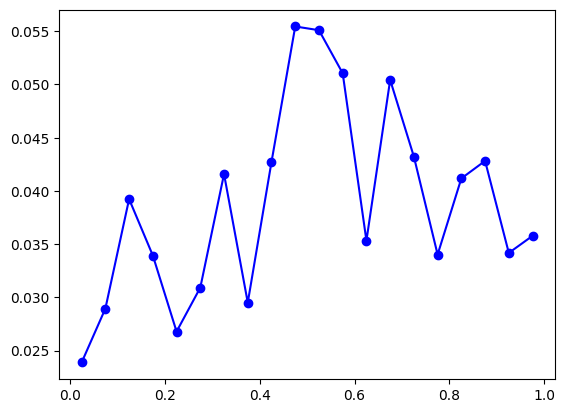

In [14]:
shapley_fda_knn = ShapleyFda(
    predict_fn=best_model_knn.predict,
    X=X_test,
    abscissa_points=fda_simulator.abscissa_points,
    target=target_test,
    domain_range=fda_simulator.domain_range,
    verbose=False,
)

values_shapley_knn = shapley_fda_knn.compute_shapley_value(
    num_intervals=num_intervals,
    num_permutations=num_permutations,
)
shapley_fda_knn.plot()

# Neural networks

In [152]:
def predict_no_verbose(predict_fn):
    def inner(*args, **kwargs):
        return predict_fn(*args, verbose=False, **kwargs)
    return inner

In [167]:
hyperopt_fnn = HyperOptFnn(
    input_shape=(X_train.shape[1], 1),
    resolution=X_train.shape[1]
)

tuner_fnn = hyperopt_fnn.build_tuner(
    objective="val_loss",
    max_trials=10,
    overwrite=True,
    directory=".",
    project_name="tune_hypermodel",
)

tuner_fnn.search(
    X_train,
    target_train,
    validation_data=(X_validation, target_validation),
    verbose=False,
)

In [172]:
params_best_fnn = tuner_fnn.get_best_hyperparameters(1)[0]
best_epochs = params_best_fnn.get("epochs")
print("best_epochs": best_epochs)
tuner_fnn.results_summary()

56
Results summary
Results in ./tune_hypermodel
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 07 summary
Hyperparameters:
hidden_layer: 2
units_0: 15
units_1: 8
epochs: 56
units_2: 12
units_3: 11
units_4: 10
Score: 5.1244944188511e-05

Trial 00 summary
Hyperparameters:
hidden_layer: 2
units_0: 14
units_1: 12
epochs: 40
Score: 5.359507485991344e-05

Trial 06 summary
Hyperparameters:
hidden_layer: 2
units_0: 8
units_1: 7
epochs: 60
units_2: 6
units_3: 10
units_4: 12
Score: 5.576415060204454e-05

Trial 02 summary
Hyperparameters:
hidden_layer: 2
units_0: 7
units_1: 11
epochs: 44
units_2: 5
units_3: 15
Score: 0.000194920867215842

Trial 01 summary
Hyperparameters:
hidden_layer: 4
units_0: 12
units_1: 8
epochs: 60
units_2: 5
units_3: 5
Score: 0.0003114677092526108

Trial 04 summary
Hyperparameters:
hidden_layer: 4
units_0: 9
units_1: 12
epochs: 40
units_2: 14
units_3: 7
Score: 0.0004845929506700486

Trial 09 summary
Hyperparameters:
hidden_layer: 4
units_0: 12
un

In [182]:
hyperopt_best_fnn = HyperOptFnn(
    input_shape=(X_train.shape[1], 1),
    resolution=X_train.shape[1]
)
model_fnn = hyperopt_best_fnn.build(params_best_fnn)
history = hyperopt_best_fnn.fit(
    params_best_fnn,
    model_fnn,
    X_full,
    target_full,
    epochs=best_epochs,
    verbose=False
)

In [183]:
model_fnn.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 101, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FunctionalDense_0               │ (None, 101, 15)        │            90 │
│ (FunctionalDense)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FunctionalDense_1               │ (None, 101, 8)         │           720 │
│ (FunctionalDense)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputLayer (FunctionalDense)   │ (None, 1)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,504 (9.79 KB)

 Trainable params: 834 (3.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,670 (6.53 KB)

In [184]:
tuner_fnn.get_best_models(1)[0].summary()

/Users/cristianpachon/Documents/technical/shapley_fda_experiments/.shapley_fda_experiments/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 101, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FunctionalDense_0               │ (None, 101, 15)        │            90 │
│ (FunctionalDense)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FunctionalDense_1               │ (None, 101, 8)         │           720 │
│ (FunctionalDense)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputLayer (FunctionalDense)   │ (None, 1)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 834 (3.26 KB)

 Trainable params: 834 (3.26 KB)

 Non-trainable params: 0 (0.00 B)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


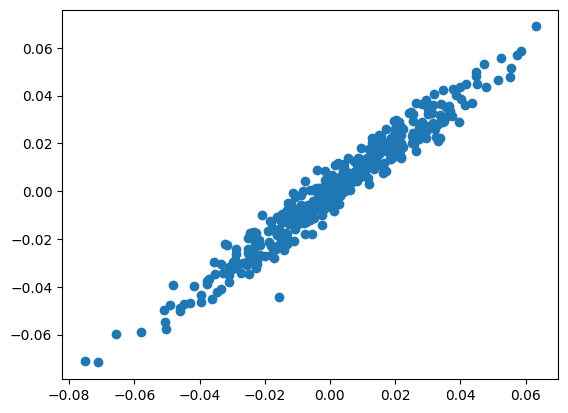

In [185]:
plt.scatter(model_fnn.predict(X_full), target_full)

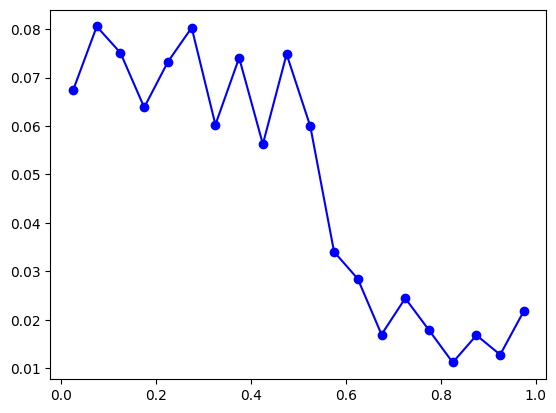

In [186]:
shapley_fda_fnn = ShapleyFda(
    predict_fn=predict_no_verbose(model_fnn.predict),
    X=X_test,
    abscissa_points=fda_simulator.abscissa_points,
    target=target_test,
    domain_range=fda_simulator.domain_range,
    verbose=False,
)

values_shapley_fnn = shapley_fda_fnn.compute_shapley_value(
    num_intervals=num_intervals,
    num_permutations=num_permutations,
)
shapley_fda_fnn.plot()

# Neural Networks no optimisation

In [67]:
input_shape = (X_train.shape[1], 1)
resolution = X_train.shape[1]
input_layer = tf.keras.layers.Input(shape=input_shape)
num_hidden_layers = 2
n_neurons = 10
n_epcohs = 50
layer_options = []
for i_layer in range(num_hidden_layers):
    dict_layer = {
        "n_neurons": n_neurons,
        "basis_options": {
            "n_functions": 6,
            "resolution": resolution,
            "basis_type": "Legendre",
        },
        "activation": "relu",
        "pooling": False
    }
    layer_options.append(dict_layer)

layer = input_layer
for i_layer, layer_option in enumerate(layer_options):
    layer = FunctionalDense(
        **layer_option,
        name=f"FunctionalDense_{i_layer}"
    )(layer)

output_layer_options = {
    "n_neurons": 1,
    "basis_options": {
        "n_functions": 3,
        "resolution": resolution,
        "basis_type": "Fourier"
    },
    "activation": "linear",
    "pooling": True
}
output_layer = FunctionalDense(
    **output_layer_options,
    name=f"OutputLayer"
)(layer)
model_fnn_no_hyper = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_fnn_no_hyper.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer="adam",
)

model_fnn_no_hyper.fit(X_full, target_full, epochs=n_epcohs)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.6496e-04
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.5599e-04
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.0809e-04
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9362e-04
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6689e-04
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2923e-04
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3039e-04
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9261e-04 
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7462e-04
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7534e-04
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4542e-04
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1496e-04 
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7898e-04
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0880e-04 
Epoch 15/50
13/13 ━━━━━━

In [164]:
model_fnn_no_hyper.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 101, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FunctionalDense_0               │ (None, 101, 10)        │            60 │
│ (FunctionalDense)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FunctionalDense_1               │ (None, 101, 10)        │           600 │
│ (FunctionalDense)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputLayer (FunctionalDense)   │ (None, 1)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,072 (8.10 KB)

 Trainable params: 690 (2.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,382 (5.40 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


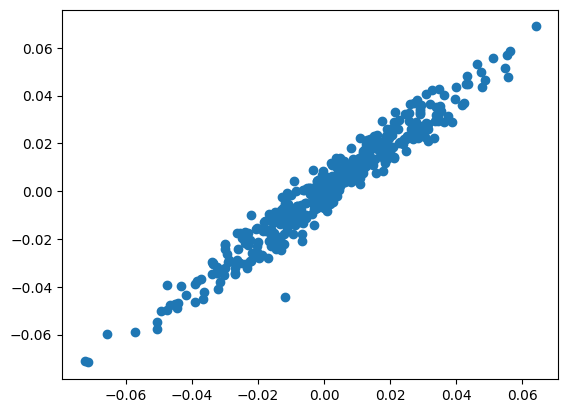

In [68]:
plt.scatter(model_fnn_no_hyper.predict(X_full), target_full)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


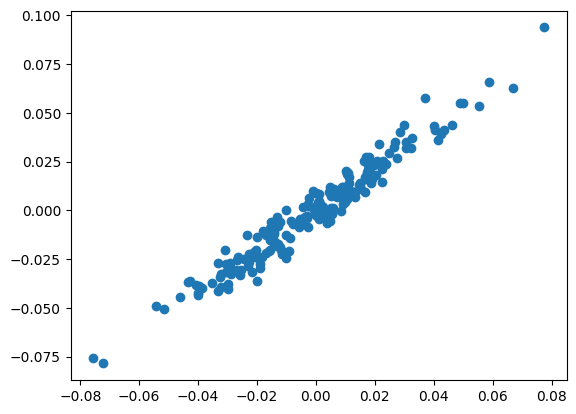

In [69]:
plt.scatter(model_fnn_no_hyper.predict(X_test), target_test)

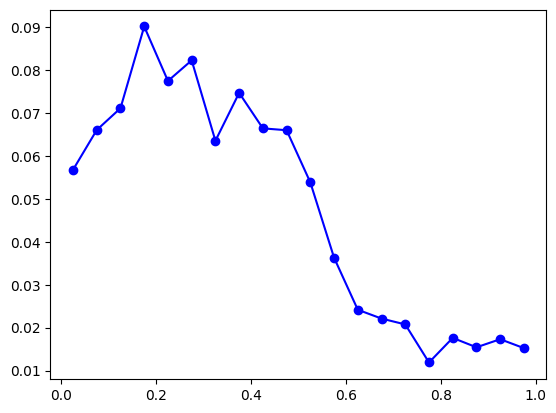

In [71]:
shapley_fda_fnn_no_hyper = ShapleyFda(
    predict_fn=predict_no_verbose(model_fnn_no_hyper.predict),
    X=X_test,
    abscissa_points=fda_simulator.abscissa_points,
    target=target_test,
    domain_range=fda_simulator.domain_range,
    verbose=False,
)

values_shapley_fnn_no_hyper = shapley_fda_fnn_no_hyper.compute_shapley_value(
    num_intervals=num_intervals,
    num_permutations=num_permutations,
)
shapley_fda_fnn_no_hyper.plot()

In [84]:
type(X_full_bspline)

skfda.representation.basis._fdatabasis.FDataBasis

In [87]:
X_full_bspline_cov = cov(X_full_grid)

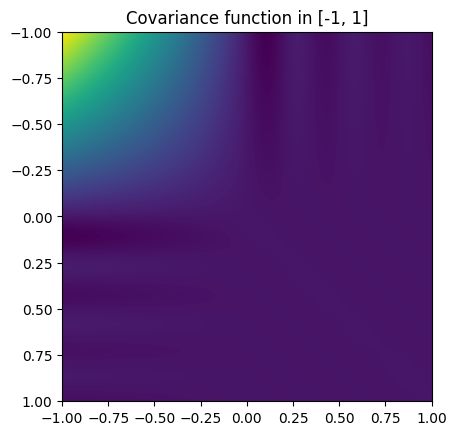

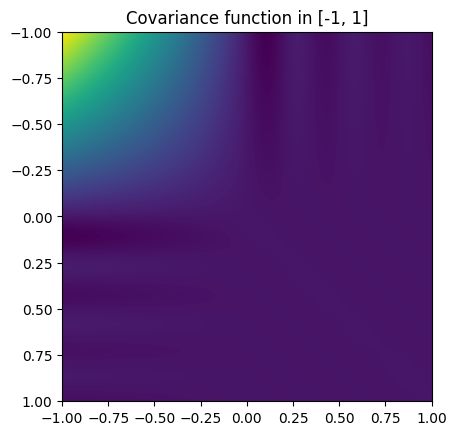

In [97]:
X_full_bspline_cov.heatmap()
#cov_fdata

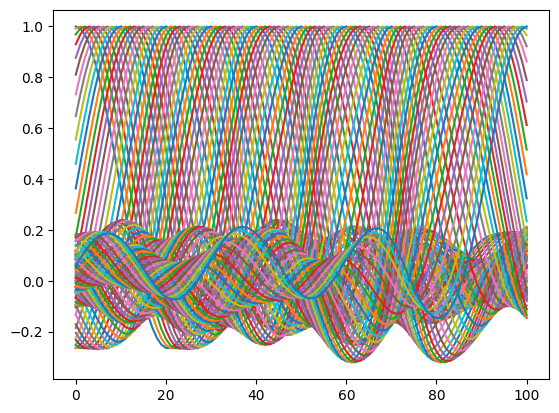

In [104]:
corr_mat = np.corrcoef(X_full.T)
plt.plot(corr_mat)